**<span style="font-size: 24px;">Import Packages</span>**

In [104]:
# packages used in this tutorial 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

**<span style="font-size: 24px;">Load CSVs</span>**

In [79]:
# Load the CSV files into dataframes
dataframes = {}
keys = [str(i).zfill(2) for i in range(1, 13)] # strings '01' to '12'
for key in keys:
    df = pd.read_csv(f'CSVafterClean/{key}.csv')
    dataframes[key] = df


**<span style="font-size: 24px;">Data Exploration - Target Variable</span>**

In [152]:
# Create an empty list to store the concatenated data
concatenated_data = []
for i in dataframes:
    df = dataframes[i]
    # Add a 'Month' column to each dataframe
    snip = df.loc[:, df.columns.isin(['time', 'prcp_total'])]
    concatenated_data.append(snip)
    
# Concatenate dataframes vertically
combined_df = pd.concat(concatenated_data, ignore_index=True) #size is [101835 rows x 2 columns]

# Convert 'time' column to datetime
combined_df['time'] = pd.to_datetime(combined_df['time'])

# Group by date and calculate the average precipitation for each day
aggregated_df = combined_df.groupby(combined_df['time'].dt.date)['prcp_total'].mean().reset_index()

print(aggregated_df)

           time  prcp_total
0    2015-01-01    1.136654
1    2015-01-02    0.258093
2    2015-01-03    0.274102
3    2015-01-04    0.086851
4    2015-01-05    0.565326
..          ...         ...
360  2015-12-27    0.192383
361  2015-12-28    0.392772
362  2015-12-29    0.158494
363  2015-12-30    1.181893
364  2015-12-31    0.337404

[365 rows x 2 columns]


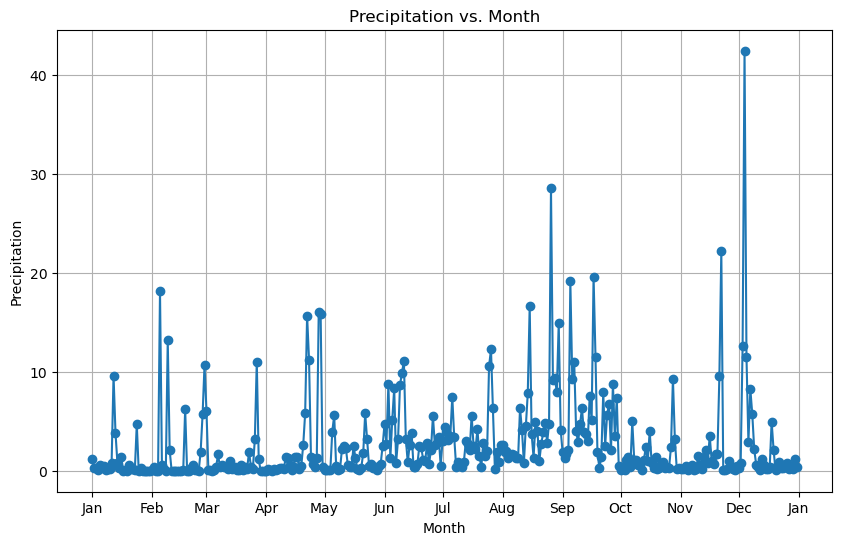

In [81]:
# Group by date and calculate the average precipitation for each day
aggregated_df = combined_df.groupby(combined_df['time'].dt.date)['prcp_total'].mean().reset_index()

# Create a line graph
plt.figure(figsize=(10, 6))
plt.plot(aggregated_df['time'], aggregated_df['prcp_total'], marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Precipitation')
plt.title('Precipitation vs. Month')
plt.grid(True)

# Format the x-axis ticks to show one label per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Set tick interval to 1 month

plt.show()

**<span style="font-size: 24px;">Data Preprocessing</span>**

In [82]:
# Assuming 'dataframes' is your dictionary of dataframes
# Extract the 'prcp_total' column from each dataframe
X = []  # Input features
y = []  # Target variable

# List of columns to exclude
target = 'next_day_prcp_total'
exclude_columns = ['time', target]

for key, df in dataframes.items():
     # Select all columns except 'time', and 'prcp_total' temporal aspects
    features = df.loc[:, ~df.columns.isin(exclude_columns)].values
    X.append(features) #a list of arrays, where each array represents the features for one dataframe. These arrays have the same number of columns (features).
    y.append(df[target].values) #a list of 1D NumPy arrays, where each array represents the 'prcp_total' values (target variable) for one dataframe

# Combine data from all dataframes
X = np.vstack(X) #vertically stacks (concatenates) these arrays on top of each other, effectively combining into a single 2D NumPy array of input features.
#where each row represents a data point (sample), and each column represents a feature.
y = np.concatenate(y) # y becomes a 1D array of target data point values of the one target variable


**<span style="font-size: 24px;">Data Visualization - Feature Importance</span>**

<AxesSubplot:>

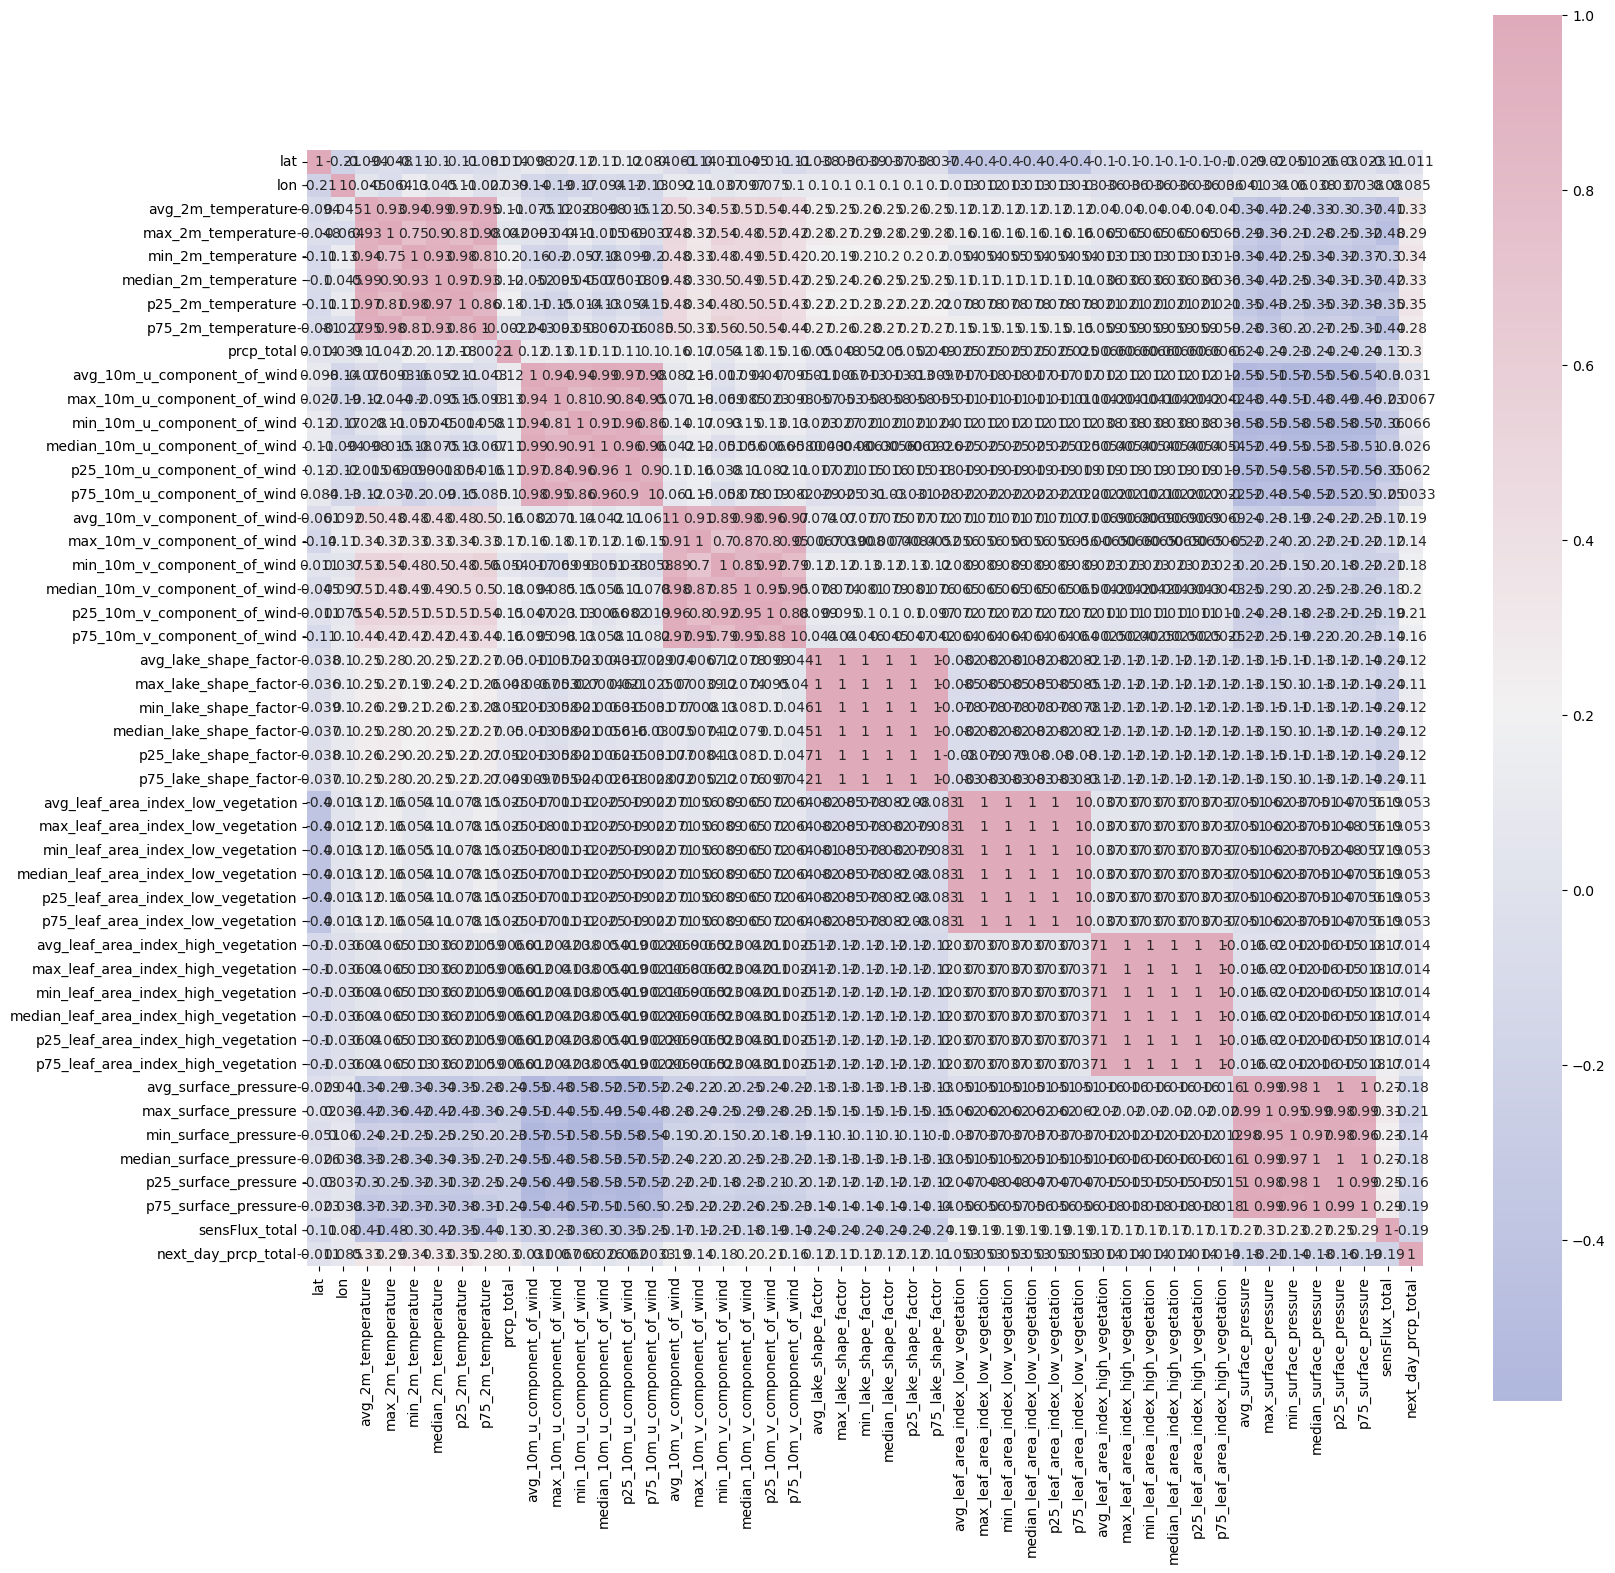

In [148]:
# Extract column names not listed in the exclusion list
col_names = [col for col in dataframes['01'].columns if col not in exclude_columns]
# Set up a standard scaler for the features
features = X
features = pd.DataFrame(features, columns=col_names) 
#full data
features['next_day_prcp_total'] = y
data = features
# Correlation amongst numeric attributes
corrmat = data.corr()
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

<AxesSubplot:>

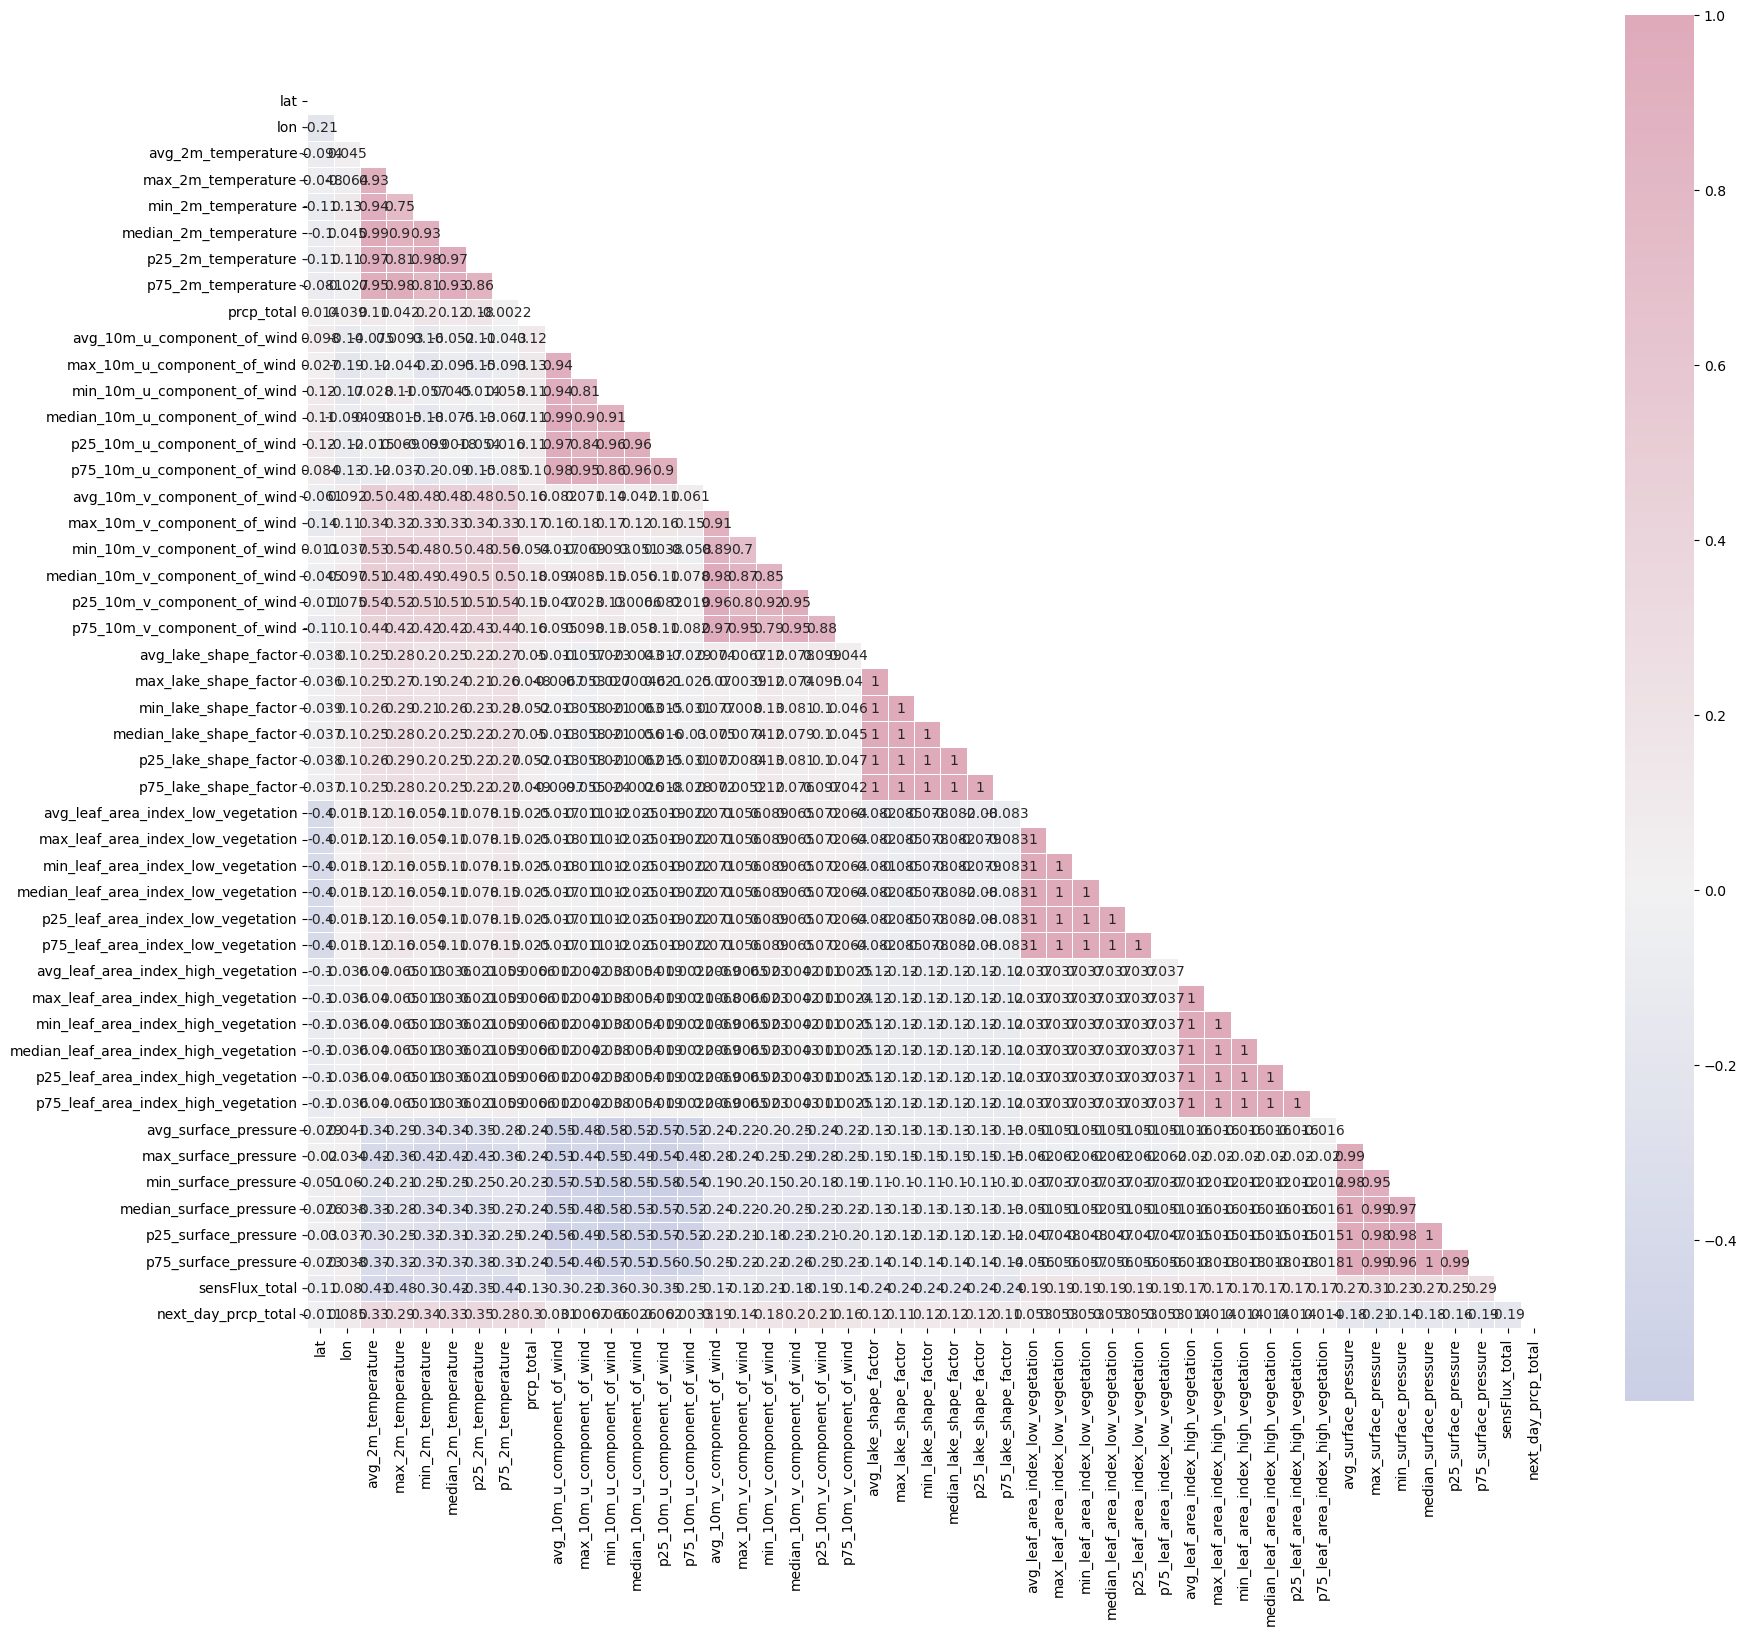

In [151]:
# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = data.corr()
mask = np.triu(np.ones_like(corr)) #this and the next line make the correlation plot half
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

**<span style="font-size: 24px;">Standardize Features</span>**

In [83]:
# Extract column names not listed in the exclusion list
col_names = [col for col in dataframes['01'].columns if col not in exclude_columns]

# Set up a standard scaler for the features
s_scaler = StandardScaler()
features = s_scaler.fit_transform(X)
features = pd.DataFrame(features, columns=col_names) 

features.describe().T

count          mean       std  \
lat                                     101835.0 -8.913200e-15  1.000005   
lon                                     101835.0  2.761931e-15  1.000005   
avg_2m_temperature                      101835.0 -4.979067e-16  1.000005   
max_2m_temperature                      101835.0  1.339659e-16  1.000005   
min_2m_temperature                      101835.0  4.242254e-17  1.000005   
median_2m_temperature                   101835.0  2.098800e-16  1.000005   
p25_2m_temperature                      101835.0 -5.738207e-16  1.000005   
p75_2m_temperature                      101835.0 -1.594195e-15  1.000005   
prcp_total                              101835.0 -9.879987e-17  1.000005   
avg_10m_u_component_of_wind             101835.0 -5.805190e-17  1.000005   
max_10m_u_component_of_wind             101835.0 -3.572425e-17  1.000005   
min_10m_u_component_of_wind             101835.0 -3.572425e-17  1.000005   
median_10m_u_component_of_wind          101835.0 -2.009489e-17  1.000005   
p25_10m_u_component_of_wind             101835.0  1.562936e-17  1.000005   
p75_10m_u_component_of_wind             101835.0 -2.902595e-17  1.000005   
avg_10m_v_component_of_wind             101835.0  5.302818e-18  1.000005   
max_10m_v_component_of_wind             101835.0 -6.251743e-17  1.000005   
min_10m_v_component_of_wind             101835.0 -1.032654e-17  1.000005   
median_10m_v_component_of_wind          101835.0 -1.925760e-17  1.000005   
p25_10m_v_component_of_wind             101835.0  4.632988e-17  1.000005   
p75_10m_v_component_of_wind             101835.0 -1.786212e-17  1.000005   
avg_lake_shape_factor                   101835.0  1.431203e-15  1.000005   
max_lake_shape_factor                   101835.0  2.012838e-15  1.000005   
min_lake_shape_factor                   101835.0  9.065028e-16  1.000005   
median_lake_shape_factor                101835.0 -7.959809e-16  1.000005   
p25_lake_shape_factor                   101835.0 -1.903433e-15  1.000005   
p75_lake_shape_factor                   101835.0 -9.165502e-16  1.000005   
avg_leaf_area_index_low_vegetation      101835.0  2.188110e-16  1.000005   
max_leaf_area_index_low_vegetation      101835.0 -4.420876e-16  1.000005   
min_leaf_area_index_low_vegetation      101835.0 -1.964834e-16  1.000005   
median_leaf_area_index_low_vegetation   101835.0  3.840357e-16  1.000005   
p25_leaf_area_index_low_vegetation      101835.0  3.840357e-16  1.000005   
p75_leaf_area_index_low_vegetation      101835.0  3.840357e-16  1.000005   
avg_leaf_area_index_high_vegetation     101835.0  1.205693e-16  1.000005   
max_leaf_area_index_high_vegetation     101835.0  8.596147e-17  1.000005   
min_leaf_area_index_high_vegetation     101835.0 -3.248674e-16  1.000005   
median_leaf_area_index_high_vegetation  101835.0  8.931062e-18  1.000005   
p25_leaf_area_index_high_vegetation     101835.0  8.931062e-18  1.000005   
p75_leaf_area_index_high_vegetation     101835.0  8.931062e-18  1.000005   
avg_surface_pressure                    101835.0 -9.415572e-15  1.000005   
max_surface_pressure                    101835.0  5.422941e-14  1.000005   
min_surface_pressure                    101835.0 -5.090817e-14  1.000005   
median_surface_pressure                 101835.0  3.916271e-15  1.000005   
p25_surface_pressure                    101835.0 -3.864917e-15  1.000005   
p75_surface_pressure                    101835.0 -5.269996e-14  1.000005   
sensFlux_total                          101835.0  2.232766e-17  1.000005   

                                             min       25%       50%  \
lat                                    -2.180517 -0.764305  0.044959   
lon                                    -2.114141 -0.716403  0.082304   
avg_2m_temperature                     -5.034658 -0.445812  0.234201   
max_2m_temperature                     -4.635613 -0.567524  0.167113   
min_2m_temperature                     -5.197687 -0.393267  0.267346   
median_2m_temperature                 

**<span style="font-size: 24px;">Outlier Removal</span>**

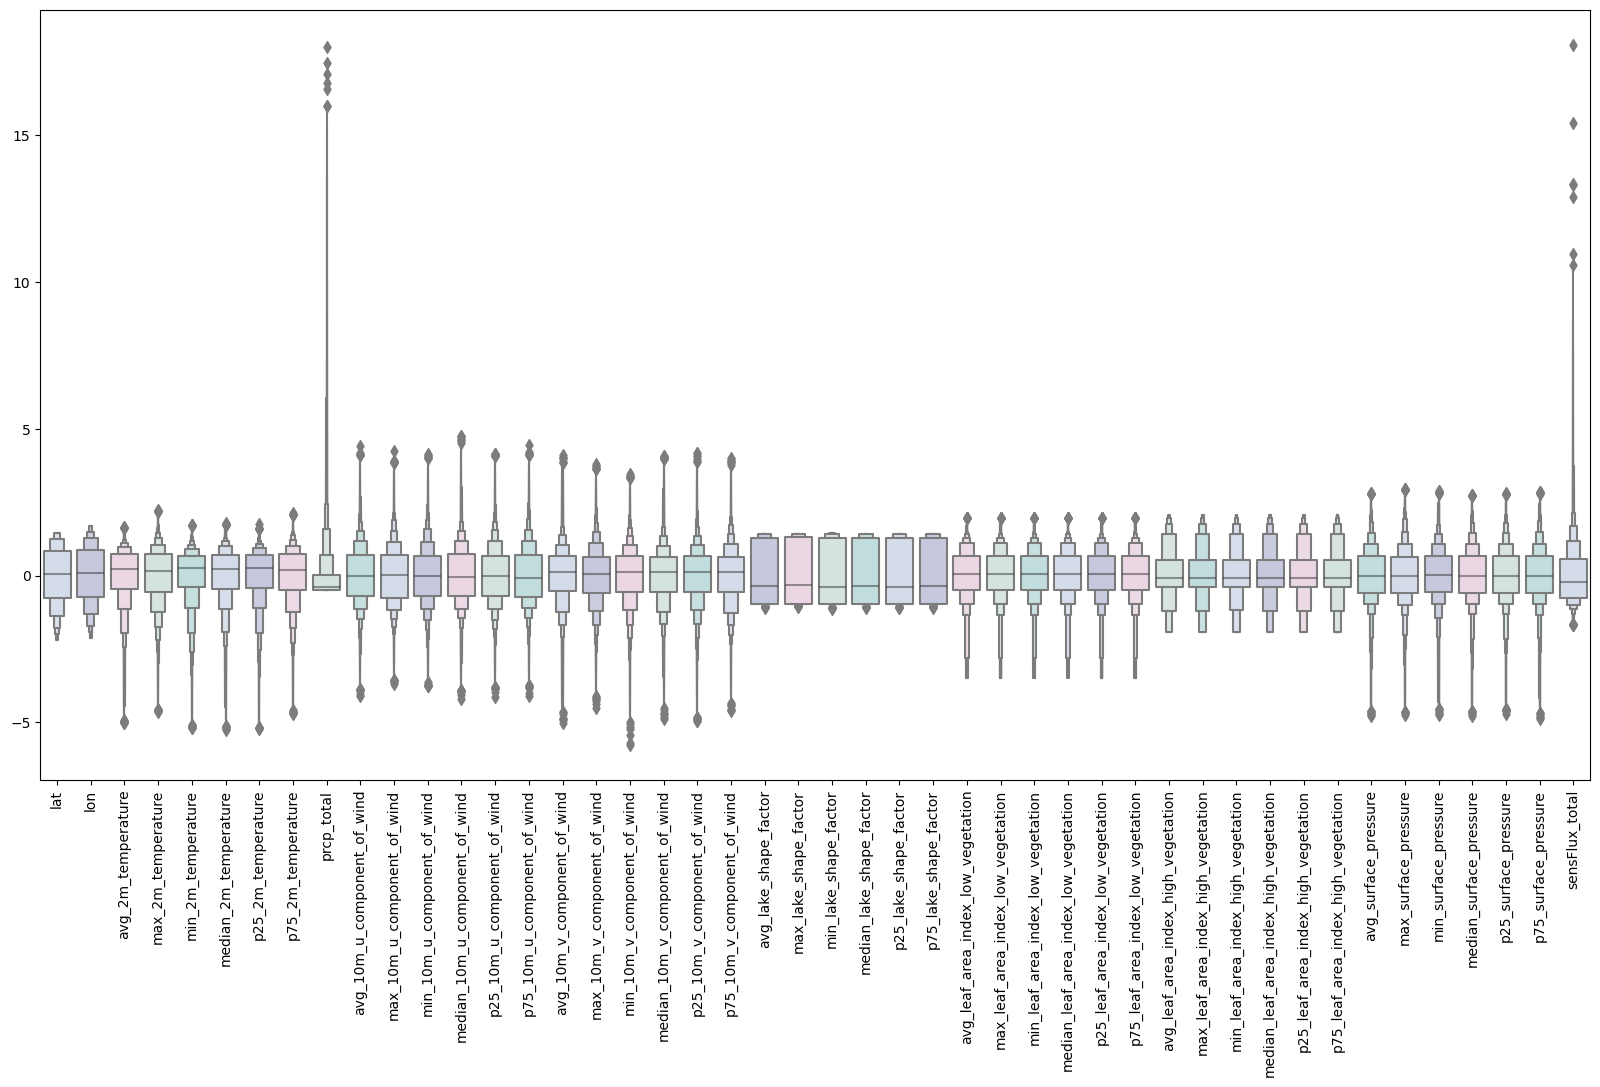

In [84]:
#Detecting outliers
#looking at the scaled features
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [85]:
#full data for 
features['next_day_prcp_total'] = y

#Dropping outlier
features = features[(features.apply(lambda x: (x > -6) & (x < 6)).all(axis=1))]


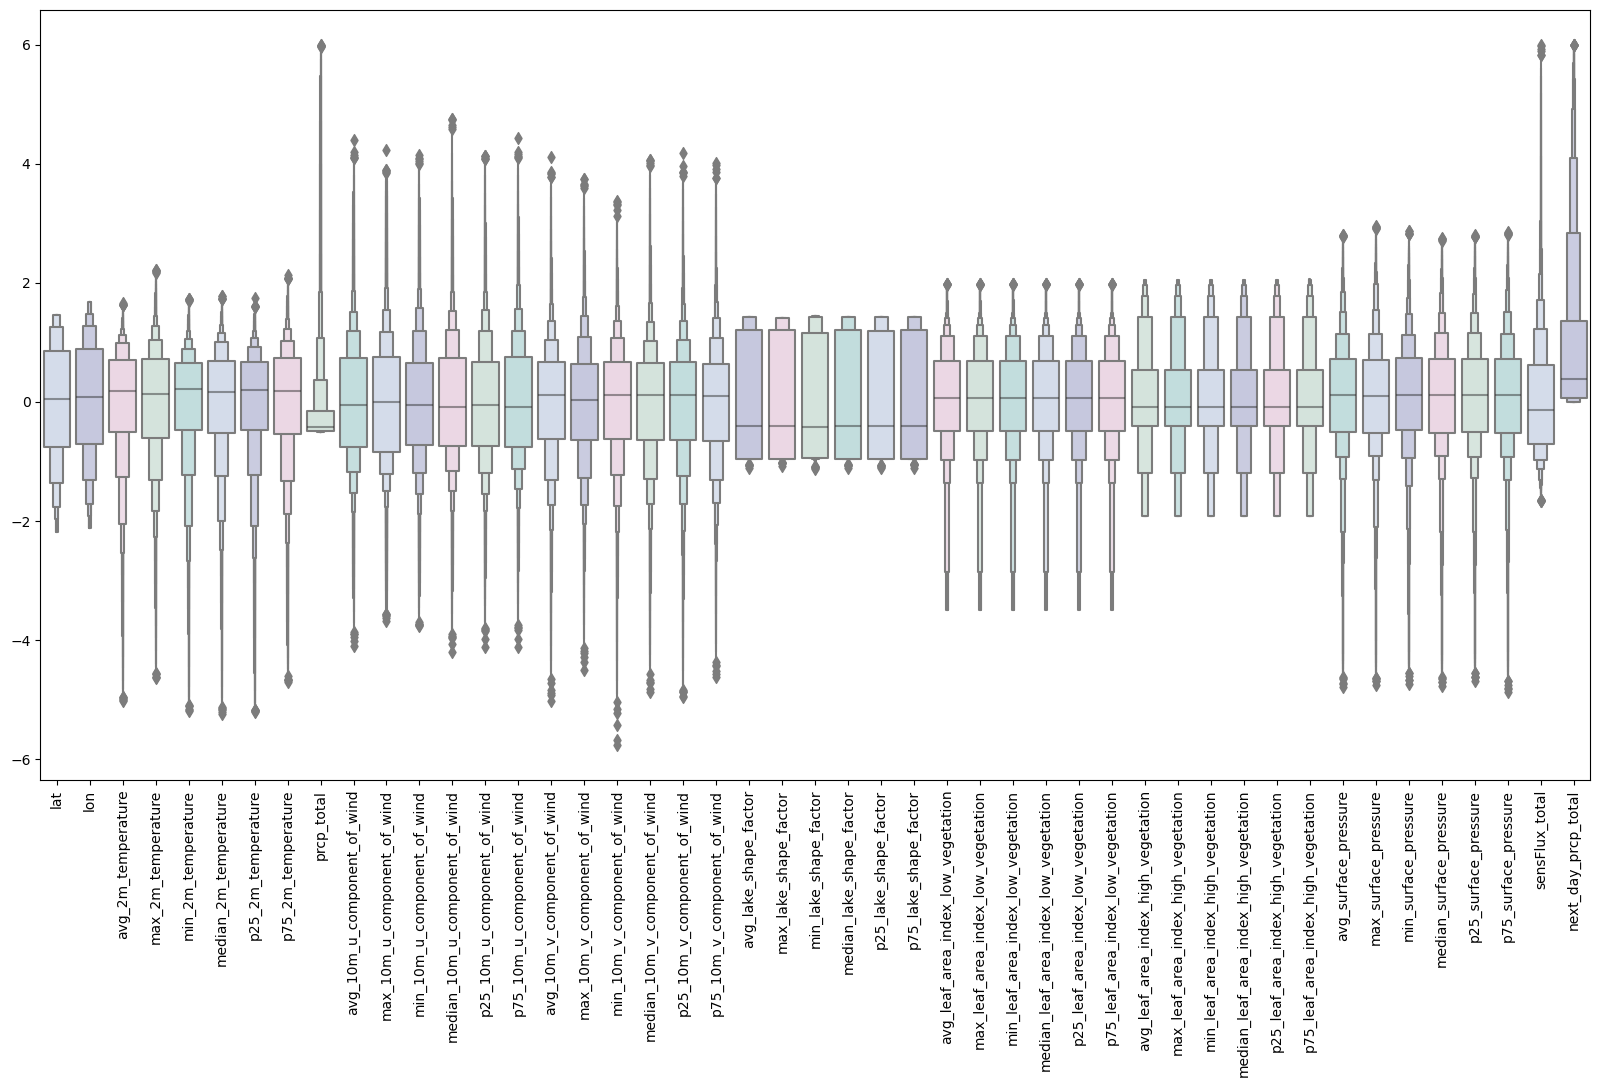

In [86]:
#looking at the scaled features without outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

**<span style="font-size: 24px;">Model Building</span>**

In [87]:
X = features.drop(['next_day_prcp_total'], axis=1)
y = features['next_day_prcp_total']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**<span style="font-size: 24px;">Regression Analysis - Neural Network</span>**

In [88]:
# Build your neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Mean Squared Error on Test Set: {loss}")

Epoch 1/10
2199/2199 [==============================] - 3s 1ms/step - loss: 1.3928 - accuracy: 0.0062 - val_loss: 1.3166 - val_accuracy: 0.0064
Epoch 2/10
2199/2199 [==============================] - 2s 998us/step - loss: 1.2228 - accuracy: 0.0064 - val_loss: 1.1690 - val_accuracy: 0.0070
Epoch 3/10
2199/2199 [==============================] - 2s 995us/step - loss: 1.1211 - accuracy: 0.0065 - val_loss: 1.0953 - val_accuracy: 0.0072
Epoch 4/10
2199/2199 [==============================] - 2s 1ms/step - loss: 1.0444 - accuracy: 0.0066 - val_loss: 1.0006 - val_accuracy: 0.0065
Epoch 5/10
2199/2199 [==============================] - 2s 990us/step - loss: 0.9754 - accuracy: 0.0065 - val_loss: 0.9700 - val_accuracy: 0.0069
Epoch 6/10
2199/2199 [==============================] - 2s 988us/step - loss: 0.9259 - accuracy: 0.0067 - val_loss: 0.9116 - val_accuracy: 0.0072
Epoch 7/10
2199/2199 [==============================] - 2s 986us/step - loss: 0.8855 - accuracy: 0.0066 - val_loss: 0.9134 - val

In [89]:
#Shape Check
print(f"Shape of y: {y.shape}, shape of X: {X.shape}")
num_features = X.shape[1]
print(f"Number of features in X: {num_features}")
num_samples = X.shape[0]
print(f"Number of data points in X: {num_samples}")

Shape of y: (87941,), shape of X: (87941, 46)
Number of features in X: 46
Number of data points in X: 87941


In [90]:
X_train

lat       lon  avg_2m_temperature  max_2m_temperature  \
79818 -0.157357  0.281981            0.232389            0.307414   
84978 -1.978201 -0.516726            0.415915           -0.266578   
73508  0.651907 -0.117373            0.570201            0.394050   
74525  1.056539 -1.315433            0.759081            0.925019   
5722   0.651907 -1.315433           -2.555482           -1.915802   
...         ...       ...                 ...                 ...   
6476   0.854223 -0.516726           -2.975007           -2.004734   
61801 -0.561989  0.481658            1.007030            1.262306   
89295  0.247275 -0.516726            0.365967            0.628660   
861   -1.573569  1.080688           -2.635922           -2.559760   
17221 -1.573569  0.481658            0.130717            0.635691   

       min_2m_temperature  median_2m_temperature  p25_2m_temperature  \
79818            0.265452               0.063941            0.195049   
84978            0.869107               0.494186            0.657885   
73508            0.559886               0.374885            0.456328   
74525            0.375065               0.689314            0.547347   
5722            -2.992342              -2.455190           -2.694530   
...                   ...                    ...                 ...   
6476            -3.115682              -3.182690           -3.356558   
61801            0.971013               0.799301            0.985170   
89295            0.094047               0.506025            0.308550   
861             -2.783746              -2.343918           -2.649935   
17221           -0.342037               0.263425           -0.165473   

       p75_2m_temperature  prcp_total  avg_10m_u_component_of_wind  ...  \
79818            0.304532   -0.490106                    -1.073375  ...   
84978            0.049858   -0.246551                     0.137905  ...   
73508            0.716668   -0.073325                     0.721354  ...   
74525            1.054752   -0.401269                     0.221986  ...   
5722            -2.237179   -0.499708                     0.160578  ...   
...                   ...         ...                          ...  ...   
6476            -2.215072   -0.499554                    -0.273495  ...   
61801            0.863329    0.122988                    -0.168159  ...   
89295            0.219992    0.071159                     1.239191  ...   
861             -2.469096   -0.499657                     1.187089  ...   
17221            0.401993   -0.491369                     0.982181  ...   

       median_leaf_area_index_high_vegetation  \
79818                               -0.138814   
84978                                0.082756   
73508                                0.818529   
74525                               -0.100549   
5722                                -0.212488   
...                                       ...   
6476                                -0.425494   
61801                               -0.525320   
89295                                1.637147   
861                                  0.050990   
17221                               -1.918176   

       p25_leaf_area_index_high_vegetation  \
79818                            -0.138814   
84978                             0.082756   
73508                             0.818529   
74525                            -0.100549   
5722                             -0.212488   
...                                    ...   
6476                             -0.425494   
61801                            -0.525320   
89295                             1.637147   
861                               0.050990   
17221                            -1.918176   

       p75_leaf_area_index_high_vegetation  avg_surface_pressure  \
79818                            -0.138814             -0.264059   
84978                             0.082756             -0.315892   
73508                             0.818529             -0.995006   
745

In [91]:
y_train

79818    0.025626
84978    1.936733
73508    4.237180
74525    3.612345
5722     0.724529
           ...   
6476     0.000811
61801    1.091071
89295    0.342891
861      0.247908
17221    0.093117
Name: next_day_prcp_total, Length: 70352, dtype: float64

In [92]:
# show a summary of the data
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                3008      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5121 (20.00 KB)
Trainable params: 5121 (20.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [93]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [mm]')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    #plt.ylim([0, 5])


....................................................................................................
...........................................................

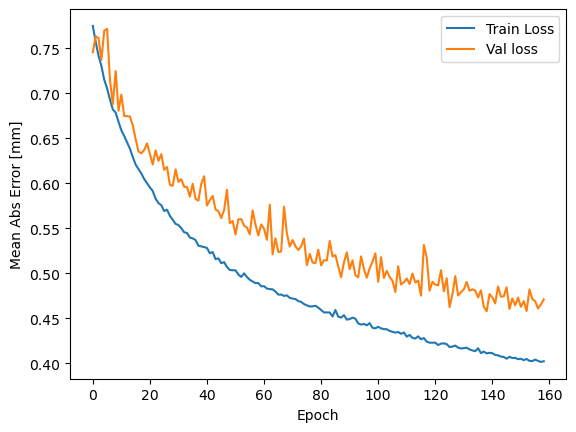

In [94]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(X_train, y_train, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [95]:
print(history_df.columns)

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')


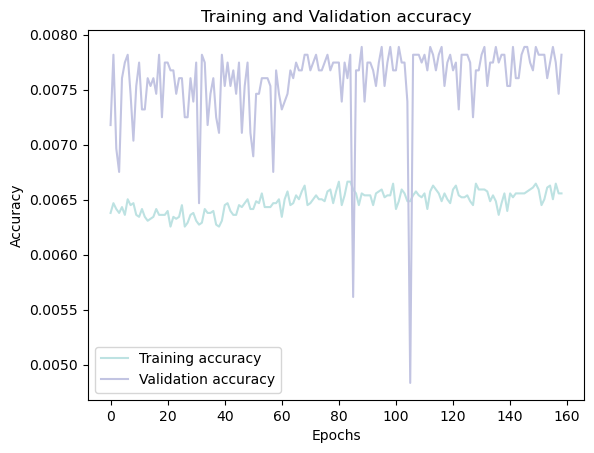

In [96]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [97]:
# Calculate MAE separately
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error on Test Set: {mae} millimeters")

550/550 [==============================] - 0s 628us/step
Mean Absolute Error on Test Set: 0.4724069517738156 millimeters


550/550 [==============================] - 0s 590us/step


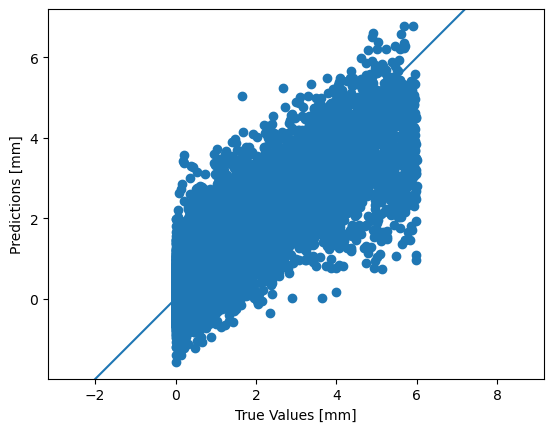

In [98]:
test_predictions = model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [99]:
np.corrcoef(y_test,test_predictions)[0,1]

0.8667583241536491

In [100]:
from sklearn.metrics import r2_score
r2_score(y_test,test_predictions)

0.750090186824038

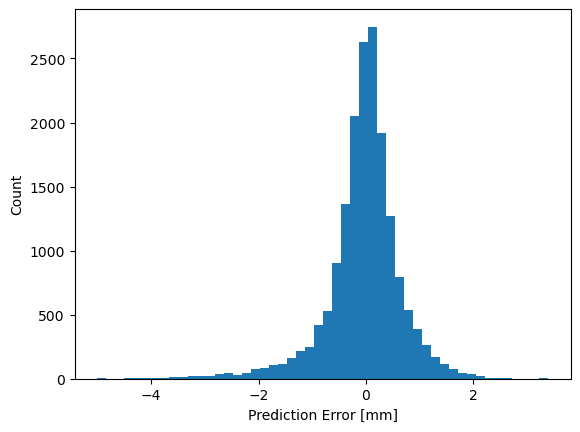

In [101]:
error = test_predictions - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [mm]")
_ = plt.ylabel("Count")

**<span style="font-size: 24px;">Categorical Analysis - Data Preprocessing</span>**

In [173]:
print('Category 0 is from 0 to ' + str(round(percentile_30, 3)) + ' mm of rain')
print('Category 1 is from ' + str(round(percentile_30, 3)) + ' mm of rain to ' + str(round(percentile_60, 3)) + ' mm of rain')
print('Category 2 is from ' + str(round(percentile_60, 3)) + ' mm of rain to the maximum')

Category 0 is from 0 to 0.104 mm of rain
Category 1 is from 0.104 mm of rain to 0.649 mm of rain
Category 2 is from 0.649 mm of rain to the maximum


In [174]:
import pandas as pd

# Calculate the 30th and 60th percentiles
percentile_30 = y_train.quantile(0.3)
percentile_60 = y_train.quantile(0.6)

# Create categorical labels based on percentiles
y_train_category = pd.cut(
    y_train,
    bins=[float('-inf'), percentile_30, percentile_60, float('inf')],
    labels=['0', '1', '2']
)

# Repeat the same process for y_test
y_test_category = pd.cut(
    y_test,
    bins=[float('-inf'), percentile_30, percentile_60, float('inf')],
    labels=['0', '1', '2']
)


**<span style="font-size: 24px;">Categorical Analysis - Pairwise Correlation</span>**

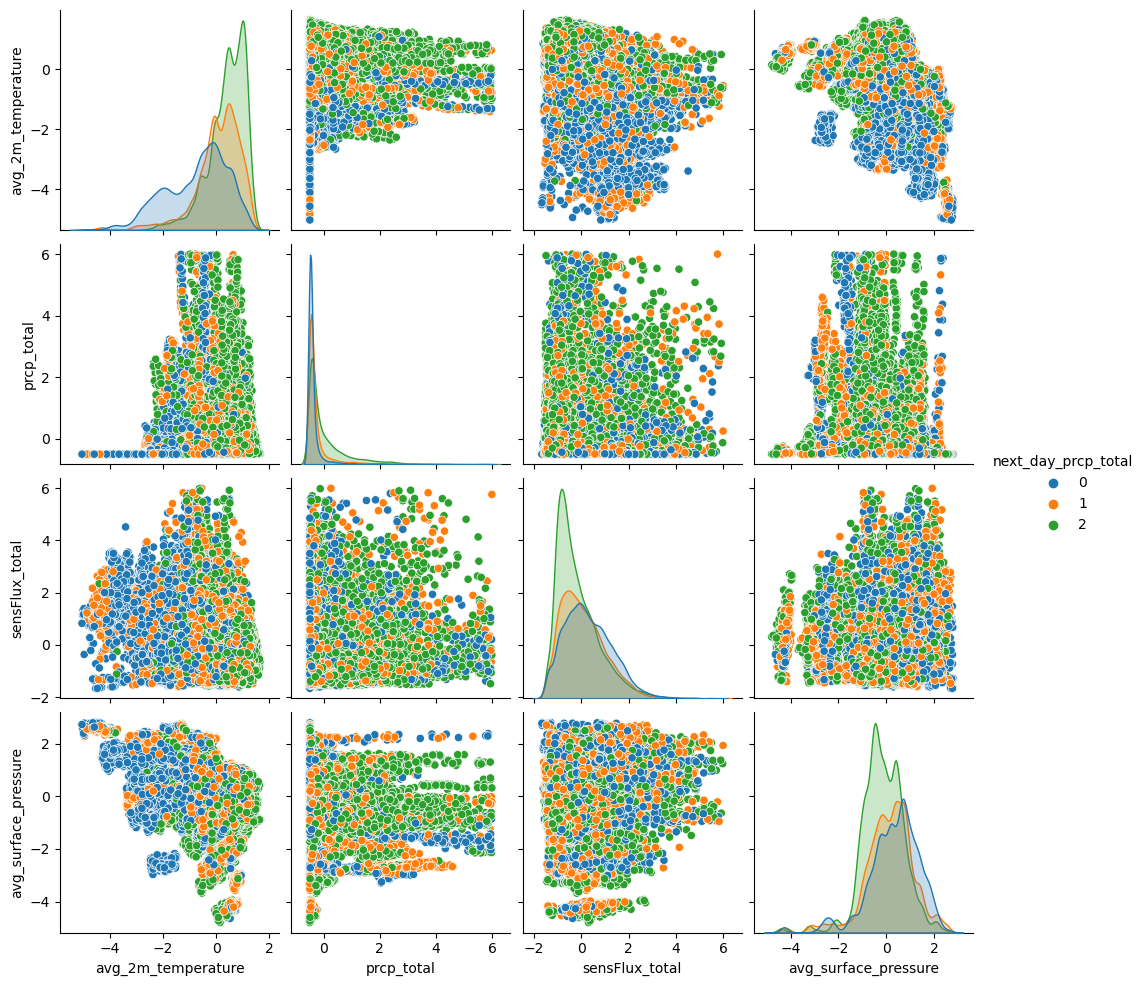

In [155]:
X_cat = pd.concat([X_train, X_test,])
y_cat = pd.concat([y_train_category, y_test_category])
X_cat['next_day_prcp_total'] = y_cat
data_cat = X_cat
sns.pairplot( data=data_cat, vars=('avg_2m_temperature','prcp_total','sensFlux_total','avg_surface_pressure'), hue='next_day_prcp_total' )


**<span style="font-size: 24px;">Categorical Analysis - Model Building</span>**


In [175]:
import time
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def run_model(model, X_train, y_train_category, X_test, y_test_category, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train_category, verbose=0)
    else:
        model.fit(X_train,y_train_category)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test_category, y_pred)
    coh_kap = cohen_kappa_score(y_test_category, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test_category,y_pred,digits=5))
    
    cm = confusion_matrix(y_test_category, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
    disp.plot()
    plt.show()
    
    return model, accuracy, coh_kap, time_taken

**<span style="font-size: 24px;">Categorical Analysis - Random Forest</span>**


Accuracy = 0.884871226334641
Cohen's Kappa = 0.8246501433687409
Time taken = 81.16864538192749
              precision    recall  f1-score   support

           0    0.93903   0.90149   0.91988      5228
           1    0.84034   0.78909   0.81391      5296
           2    0.87824   0.94437   0.91011      7065

    accuracy                        0.88487     17589
   macro avg    0.88587   0.87832   0.88130     17589
weighted avg    0.88490   0.88487   0.88405     17589



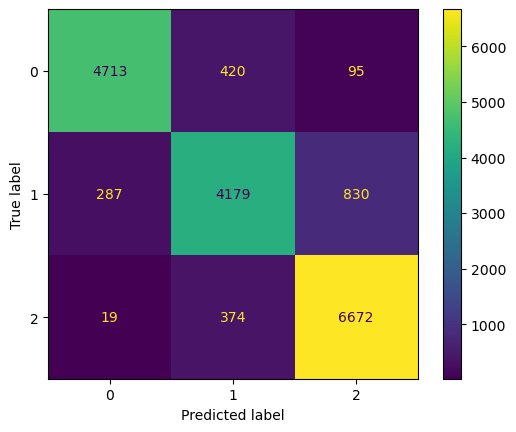

In [145]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train_category, X_test, y_test_category)

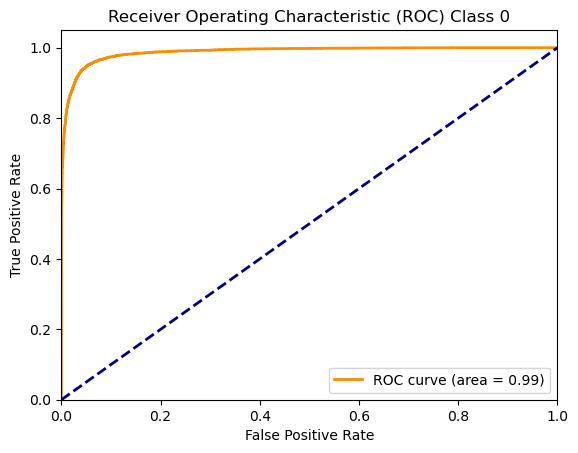

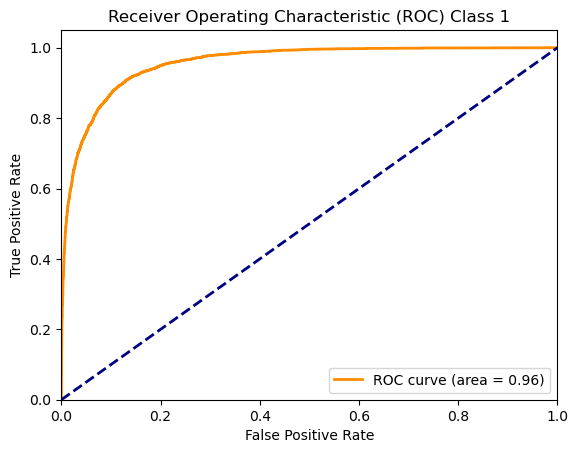

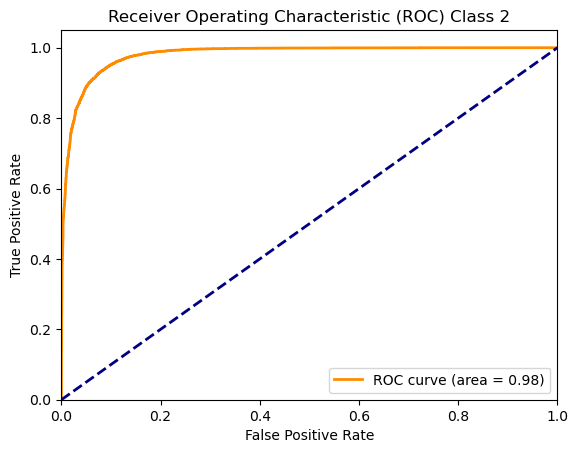

In [139]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the labels
y_test_binarized = label_binarize(y_test_category, classes=['0', '1', '2'])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

probs = model_rf.predict_proba(X_test)  # Calculate predicted probabilities


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Class {}'.format(i))
    plt.legend(loc='lower right')
    plt.show()


**<span style="font-size: 24px;">Categorical Analysis - XGBoost</span>**


Accuracy = 0.930638467223833
Cohen's Kappa = 0.8947574082825525
Time taken = 32.40622544288635
              precision    recall  f1-score   support

           0    0.95433   0.94338   0.94883      5228
           1    0.88925   0.88236   0.88579      5296
           2    0.94390   0.95740   0.95060      7065

    accuracy                        0.93064     17589
   macro avg    0.92916   0.92771   0.92841     17589
weighted avg    0.93055   0.93064   0.93056     17589



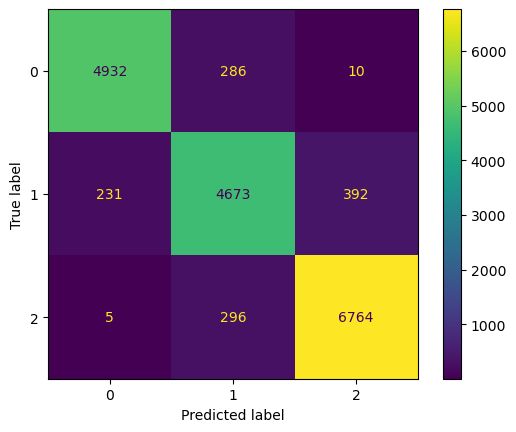

In [179]:
y_train_category = y_train_category.astype(int)
y_test_category = y_test_category.astype(int)

import xgboost as xgb
params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train_category, X_test, y_test_category)